1. Preparation

In [521]:
# 1.1 Import needed libraries

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import keras
print('Keras version:', keras.__version__)

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['axes.grid'] = False

# Helper libraries:
import os
import sys
import time
import datetime

import numpy as np
import pandas as pd
import sklearn
from   sklearn.model_selection import train_test_split

import IPython
import IPython.display
import seaborn as sns

# GPU detection:
import platform
import subprocess

# Data collection:
import requests
from datetime import datetime, timedelta

# Technical analysis:
import pandas_ta as ta

# Cyclical time-features:
import calendar

# Feature scaling:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Model creation:
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix



TensorFlow version: 2.10.1
Keras version: 2.10.0


In [522]:
# 1.2 Test for GPU and determine what GPU we have

gpu_devices = tf.config.list_physical_devices('GPU')

gpu_name = tf.test.gpu_device_name()
if gpu_name != '':
    print('TF-GPU-devname:',tf.test.gpu_device_name())
    sys_details = tf.sysconfig.get_build_info()
    physical_devices = tf.config.list_physical_devices('GPU')
    print("Num GPUs:", len(physical_devices))
    if platform.system() == "Darwin":
        print('GPU on Mac!')
    else:
        cuda_version = sys_details["cuda_version"]
        print('TF-cuda version:',cuda_version)
        if len(physical_devices)>0:
            process = subprocess.Popen(['nvidia-smi','-L'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(process.communicate())
        # If possible to run code with 16 bits float instead of 32 bits float, this code activates such functionality:
        if gpu_devices:
            details = tf.config.experimental.get_device_details(gpu_devices[0])
            compute_capability=details.get('compute_capability')
            print("Compute capability:",compute_capability)
            if compute_capability[0]>6:
                print("Turning on mixed_float16")
                policy = keras.mixed_precision.Policy('mixed_float16')
                keras.mixed_precision.set_global_policy(policy)
else:
    print('TF-device CPU')

TF-GPU-devname: /device:GPU:0
Num GPUs: 1
TF-cuda version: 64_112
(b'GPU 0: NVIDIA GeForce RTX 3070 Ti (UUID: GPU-fcc7dd50-523b-0d8c-356a-fd4d3a81dc8c)\r\n', b'')
Compute capability: (8, 6)
Turning on mixed_float16


2. Custom variables

In [523]:
# 2.1 Data collection variables

# Candle size:
interval = '1h'

# Number of candles to download:
num_candles = 3*365*24


In [524]:
# 2.2 Label variables

predetermined_thresholds = {
    '1xcandle': [ -0.003, 0.003]
}

# Define time horizons (how many candles ahead to predict):
time_horizons = {
    '1xcandle': 4
}

# 4.6 Label choice

# Option 1: Keep using original approach
strategy='independent'

# Option 2: Try oscillation labels
#strategy='oscillation'

# Option 3: Compare both to see which is better
#strategy='compare'


In [525]:
# 2.3 Final data processing
 
# Window size:
window_size = 24

# Number of segments to split training data into:
segments = 10

In [526]:
# 2.4 Choose model

chosen_model = lstm_deep

3. Data collection and inspection/cleanup

In [527]:
# 3.1 Collect Bitcoin OHLCV data and save it to raw_data_df

def fetch_dataset(num_candles, symbol='BTCUSDT', delay=0.1):
    """
    Fetch more than 1000 candles by making multiple requests
    
    Parameters:
    num_candles (int): Total number of candles to fetch
    symbol (str): Trading pair symbol
    delay (float): Delay between requests to avoid rate limits
    
    Returns:
    pandas.DataFrame: Combined OHLCV data
    """
    
    all_data = []
    remaining = num_candles
    end_time = None
    
    while remaining > 0:
        batch_size = min(remaining, 1000)
        
        base_url = 'https://api.binance.com/api/v3/klines'
        params = {
            'symbol': symbol,
            'interval': interval,
            'limit': batch_size
        }
        
        if end_time:
            params['endTime'] = end_time
        
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if not data:
                break
                
            all_data.extend(data)
            
            # Set end_time for next batch (oldest timestamp from current batch)
            end_time = data[0][0] - 1
            remaining -= len(data)
            
            print(f"Fetched {len(data)} candles, {remaining} remaining...")
            
            if remaining > 0:
                time.sleep(delay)
                
        except Exception as e:
            print(f"Error in batch fetch: {e}")
            break
    
    if not all_data:
        return None
    
    # Convert to DataFrame
    raw_data_df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    # Keep only OHLCV columns and convert types
    raw_data_df = raw_data_df[['timestamp', 'open', 'high', 'low', 'close', 'volume']].copy()
    
    # Convert timestamp to datetime
    raw_data_df['timestamp'] = pd.to_datetime(raw_data_df['timestamp'], unit='ms')
    
    # Convert price and volume columns to float
    for col in ['open', 'high', 'low', 'close', 'volume']:
        raw_data_df[col] = raw_data_df[col].astype(float)
    
    # Set timestamp as index and sort
    raw_data_df.set_index('timestamp', inplace=True)
    raw_data_df.sort_index(inplace=True)
    
    # Remove duplicates if any
    raw_data_df = raw_data_df[~raw_data_df.index.duplicated(keep='first')]
    
    print(f"Successfully fetched {len(raw_data_df)} total candles")
    print(f"Date range: {raw_data_df.index.min()} to {raw_data_df.index.max()}")
    
    return raw_data_df

# Fetch candles (multiple requests)
raw_data_df = fetch_dataset(num_candles)
    
if raw_data_df is not None:
    print("\nDataFrame info:")
    print(raw_data_df.info())
    print("\nFirst few rows:")
    print(raw_data_df.head())
    print("\nLast few rows:")
    print(raw_data_df.tail())

Fetched 1000 candles, 25280 remaining...
Fetched 1000 candles, 24280 remaining...
Fetched 1000 candles, 23280 remaining...
Fetched 1000 candles, 22280 remaining...
Fetched 1000 candles, 21280 remaining...
Fetched 1000 candles, 20280 remaining...
Fetched 1000 candles, 19280 remaining...
Fetched 1000 candles, 18280 remaining...
Fetched 1000 candles, 17280 remaining...
Fetched 1000 candles, 16280 remaining...
Fetched 1000 candles, 15280 remaining...
Fetched 1000 candles, 14280 remaining...
Fetched 1000 candles, 13280 remaining...
Fetched 1000 candles, 12280 remaining...
Fetched 1000 candles, 11280 remaining...
Fetched 1000 candles, 10280 remaining...
Fetched 1000 candles, 9280 remaining...
Fetched 1000 candles, 8280 remaining...
Fetched 1000 candles, 7280 remaining...
Fetched 1000 candles, 6280 remaining...
Fetched 1000 candles, 5280 remaining...
Fetched 1000 candles, 4280 remaining...
Fetched 1000 candles, 3280 remaining...
Fetched 1000 candles, 2280 remaining...
Fetched 1000 candles, 12

In [528]:
# 3.2 Calculate cyclical time-features:

features_df = raw_data_df.copy()


# Quarter-hour of day (96 quarters in 24 hours):
features_df['minute_of_day'] = ((features_df.index.hour * 60) + (features_df.index.minute))

features_df['minute_day_sin'] = np.sin(2 * np.pi * features_df['minute_of_day'] / 1440)
features_df['minute_day_cos'] = np.cos(2 * np.pi * features_df['minute_of_day'] / 1440)


# Day of week (7 days in 1 week):
features_df['day_of_week'] = features_df.index.dayofweek.astype(int)

features_df['day_week_sin'] = np.sin(2 * np.pi * features_df['day_of_week'] / 7)
features_df['day_week_cos'] = np.cos(2 * np.pi * features_df['day_of_week'] / 7)


# Month of year (12 months in 1 year):
features_df['month'] = features_df.index.month.astype(int)

features_df['month_sin'] = np.sin(2 * np.pi * features_df['month'] / 12)
features_df['month_cos'] = np.cos(2 * np.pi * features_df['month'] / 12)


# Year, day of year & day of month:
features_df['year'] = features_df.index.year.astype(int)
features_df['day_of_year'] = features_df.index.dayofyear.astype(int)
features_df['day_of_month'] = features_df.index.day.astype(int)


# Day of month and day of year special calculations:


# Day of month:
def get_days_in_month(row):
    return calendar.monthrange(int(row['year']), int(row['month']))[1]
    
# Get actual number of days for each month/year combination
features_df['days_in_month'] = features_df.apply(get_days_in_month, axis=1)
    
# Accurate day of month cyclical encoding
features_df['day_month_sin'] = np.sin(2 * np.pi * features_df['day_of_month'] / features_df['days_in_month'])
features_df['day_month_cos'] = np.cos(2 * np.pi * features_df['day_of_month'] / features_df['days_in_month'])

# Day of year:
def get_days_in_year(year):
    return 366 if calendar.isleap(int(year)) else 365
    
# Day of year (1-365 or 1-366)
features_df['days_in_year'] = features_df['year'].apply(get_days_in_year)
    
# Accurate day of year cyclical encoding
features_df['day_year_sin'] = np.sin(2 * np.pi * features_df['day_of_year'] / features_df['days_in_year'])
features_df['day_year_cos'] = np.cos(2 * np.pi * features_df['day_of_year'] / features_df['days_in_year'])

In [ ]:
# 3.3 Process price action data for LSTM

# 1. Log Return (close-to-close)
# This captures the overall movement from one period to the next
# Uses shift(1) to get the previous close
features_df['log_return'] = np.log(raw_data_df['close'] / raw_data_df['close'].shift(1))
	
# 2. Intraday Return (open-to-close)
# This tells what happened within each period
# Positive = bullish day, Negative = bearish day
features_df['intraday_return'] = np.log(raw_data_df['close'] / raw_data_df['open'])
		
# 3. High-Low Ratio
# This measures volatility as a fraction
# 0.02 = 2% range, 0.10 = 10% range, etc.
features_df['high_low_ratio'] = (raw_data_df['high'] / raw_data_df['low']) - 1
		
# 4. Close Position
# 0 = at the low (very bearish), 1 = at the high (very bullish)
# Need to handle cases where high == low (no range)
daily_range = raw_data_df['high'] - raw_data_df['low']
features_df['close_position'] = np.where(
	daily_range > 0,  # Only calculate if there's a range
	(raw_data_df['close'] - raw_data_df['low']) / daily_range,
	0.5)  # If high == low, we're in the "middle" by default

In [530]:
# 3.4 Calculate technical indicators:

# Core trend indicators
features_df['sma_20'] = ta.sma(raw_data_df['close'], length=20)

# Momentum indicators  
features_df['rsi'] = ta.rsi(raw_data_df['close'], length=14)

# Volatility
bb = ta.bbands(raw_data_df['close'], length=20, std=2.0)  # Explicit parameters
#raw_data_df['bb_width'] = (bb['BBU_20_2.0'] - bb['BBL_20_2.0']) / bb['BBM_20_2.0']
features_df['bb_upper'] = bb['BBU_20_2.0']
features_df['bb_lower'] = bb['BBL_20_2.0']
features_df['bb_width'] = bb['BBB_20_2.0']        # Bandwidth (already calculated!)
features_df['bb_position'] = bb['BBP_20_2.0']     # Where price is within bands (0-1)

# Volume confirmation
features_df['volume_sma'] = ta.sma(raw_data_df['volume'], length=20)
features_df['volume_ratio'] = raw_data_df['volume'] / features_df['volume_sma']

# Replace SMA20 a price to SMA ratio as it's a common benchmark in trading
features_df['price_to_sma_ratio'] = raw_data_df['close'] / features_df['sma_20']

# Calculate 5-period momentum (about 1.25 hours on 15-min timeframe):
features_df['momentum_5'] = features_df['log_return'].rolling(5).sum()

4. Label creation

In [531]:
# 4.1 Calculate labels

def create_price_movement_labels(raw_data_df, threshold_dict, time_horizons):
    """
    Create binary labels indicating if price crosses thresholds within time windows.
    Now properly handles decimal percentages in column names.
    """
    
    # Initialize labels dictionary
    labels = {}
    
    # Process each timeframe with its specific thresholds
    for horizon, n_periods in time_horizons.items():
        # Get the thresholds specific to this timeframe
        if horizon not in threshold_dict:
            raise ValueError(f"No thresholds defined for timeframe: {horizon}")
        
        thresholds = threshold_dict[horizon]
        
        # Process each threshold for this timeframe
        for threshold in thresholds:
            # Create descriptive column name that handles decimals properly
            # Convert to percentage and handle decimal places intelligently
            pct_value = abs(threshold * 100)
            
            # Format the percentage to avoid unnecessary decimals
            if pct_value == int(pct_value):
                # Whole number percentage (1%, 2%, etc.)
                pct_str = f"{int(pct_value)}"
            elif pct_value * 10 == int(pct_value * 10):
                # One decimal place (0.5%, 1.5%, etc.)
                pct_str = f"{pct_value:.1f}".replace('.', '_')
            else:
                # Two decimal places (0.25%, 0.75%, etc.)
                pct_str = f"{pct_value:.2f}".replace('.', '_')
            
            # Create column name
            if threshold > 0:
                col_name = f'label_{horizon}_up_{pct_str}pct'
            else:
                col_name = f'label_{horizon}_down_{pct_str}pct'
            
            # Initialize the label array
            label_values = np.zeros(len(raw_data_df))
            
            # Mark the last n_periods as NaN since we can't look forward
            label_values[-n_periods:] = np.nan
            
            # Calculate labels for each valid position
            for i in range(len(raw_data_df) - n_periods):
                current_close = raw_data_df['close'].iloc[i]
                
                # Get the future window
                future_highs = raw_data_df['high'].iloc[i+1:i+n_periods+1].values
                future_lows = raw_data_df['low'].iloc[i+1:i+n_periods+1].values
                
                if threshold > 0:
                    # For positive thresholds, check if any high crosses threshold
                    max_high = np.max(future_highs)
                    max_return = (max_high - current_close) / current_close
                    label_values[i] = 1 if max_return >= threshold else 0
                else:
                    # For negative thresholds, check if any low crosses threshold
                    min_low = np.min(future_lows)
                    min_return = (min_low - current_close) / current_close
                    label_values[i] = 1 if min_return <= threshold else 0
            
            labels[col_name] = label_values
    
    # Convert to DataFrame, preserving the original index
    labels_df = pd.DataFrame(labels, index=raw_data_df.index)
    
    # Sort columns for consistent ordering
    labels_df = labels_df.reindex(sorted(labels_df.columns), axis=1)
    
    return labels_df

In [532]:
# 4.3 Alternative label creation for oscillation detection

def create_oscillation_labels(raw_data_df, threshold_dict, time_horizons):
    
    # First, get the original individual threshold labels
    # Use existing function to avoid duplicating that logic
    individual_labels = create_price_movement_labels(raw_data_df, threshold_dict, time_horizons)
    
    # Now create composite labels for oscillation and directional movements
    oscillation_labels = {}
    
    # Process each timeframe
    for horizon, n_periods in time_horizons.items():
        if horizon not in threshold_dict:
            continue
            
        thresholds = threshold_dict[horizon]
        
        # Find pairs of opposite thresholds
        # Match positive and negative thresholds of the same magnitude
        positive_thresholds = [t for t in thresholds if t > 0]
        negative_thresholds = [t for t in thresholds if t < 0]
        
        # Sort to ensure matching
        positive_thresholds.sort()
        negative_thresholds.sort(key=abs)  # Sort by absolute value
        
        # Create labels for each threshold pair
        for pos_threshold, neg_threshold in zip(positive_thresholds, negative_thresholds):
            # Get column names for the individual thresholds
            # Format the percentage strings (handling decimals)
            pos_pct_str = format_threshold_string(pos_threshold * 100)
            neg_pct_str = format_threshold_string(abs(neg_threshold * 100))
            
            # Column names from the individual labels
            pos_col = f'label_{horizon}_up_{pos_pct_str}pct'
            neg_col = f'label_{horizon}_down_{neg_pct_str}pct'
            
            # Get the individual predictions
            pos_crosses = individual_labels[pos_col].values
            neg_crosses = individual_labels[neg_col].values
            
            # Create three types of labels:
            
            # 1. Oscillation: BOTH thresholds crossed
            oscillation_col = f'label_{horizon}_oscillation_{neg_pct_str}pct'
            oscillation_labels[oscillation_col] = (pos_crosses == 1) & (neg_crosses == 1)
            
            # 2. Pure upward: ONLY positive threshold crossed
            up_only_col = f'label_{horizon}_up_only_{pos_pct_str}pct'
            oscillation_labels[up_only_col] = (pos_crosses == 1) & (neg_crosses == 0)
            
            # 3. Pure downward: ONLY negative threshold crossed
            down_only_col = f'label_{horizon}_down_only_{neg_pct_str}pct'
            oscillation_labels[down_only_col] = (pos_crosses == 0) & (neg_crosses == 1)
            
            # Print statistics for understanding
            total_valid = len(pos_crosses) - np.sum(np.isnan(pos_crosses))
            if total_valid > 0:
                osc_rate = np.sum(oscillation_labels[oscillation_col]) / total_valid
                up_rate = np.sum(oscillation_labels[up_only_col]) / total_valid
                down_rate = np.sum(oscillation_labels[down_only_col]) / total_valid
                neither_rate = 1 - osc_rate - up_rate - down_rate
                
                print(f"\n{horizon} ±{abs(neg_threshold)*100:.2f}% threshold patterns:")
                print(f"  Oscillation (both):  {osc_rate:6.2%}")
                print(f"  Pure up only:        {up_rate:6.2%}")
                print(f"  Pure down only:      {down_rate:6.2%}")
                print(f"  Neither:             {neither_rate:6.2%}")
    
    # Convert to DataFrame
    labels_df = pd.DataFrame(oscillation_labels, index=raw_data_df.index)
    
    # Sort columns for consistency
    labels_df = labels_df.reindex(sorted(labels_df.columns), axis=1)
    
    return labels_df

def format_threshold_string(pct_value):
    if pct_value == int(pct_value):
        # Whole number percentage
        return f"{int(pct_value)}"
    elif pct_value * 10 == int(pct_value * 10):
        # One decimal place
        return f"{pct_value:.1f}".replace('.', '_')
    else:
        # Two decimal places
        return f"{pct_value:.2f}".replace('.', '_')

In [533]:
# 4.4 Comparison function to understand the difference between label types

def compare_label_strategies(raw_data_df, threshold_dict, time_horizons):
    
    print("COMPARING LABEL STRATEGIES")
    print("="*70)
    
    # Generate both types of labels
    print("\n1. Creating original independent labels...")
    independent_labels = create_price_movement_labels(raw_data_df, threshold_dict, time_horizons)
    
    print("\n2. Creating oscillation-focused labels...")
    oscillation_labels = create_oscillation_labels(raw_data_df, threshold_dict, time_horizons)
    
    # Analyze the differences
    print("\n3. ANALYSIS OF TRADING OPPORTUNITIES")
    print("-"*70)
    
    # For each threshold pair, calculate expected outcomes
    for horizon in time_horizons.keys():
        thresholds = threshold_dict[horizon]
        positive_thresholds = [t for t in thresholds if t > 0]
        
        for threshold in positive_thresholds:
            pct_str = format_threshold_string(threshold * 100)
            
            # Get relevant columns
            pos_col = f'label_{horizon}_up_{pct_str}pct'
            neg_col = f'label_{horizon}_down_{pct_str}pct'
            osc_col = f'label_{horizon}_oscillation_{pct_str}pct'
            
            if pos_col in independent_labels.columns and osc_col in oscillation_labels.columns:
                # Calculate statistics
                pos_events = independent_labels[pos_col].sum()
                neg_events = independent_labels[neg_col].sum()
                osc_events = oscillation_labels[osc_col].sum()
                
                # Estimate correlation factor
                expected_if_independent = (pos_events/len(independent_labels)) * (neg_events/len(independent_labels)) * len(independent_labels)
                actual_joint = osc_events
                
                if expected_if_independent > 0:
                    correlation_factor = actual_joint / expected_if_independent
                else:
                    correlation_factor = 0
                
                print(f"\n{horizon} ±{threshold*100:.2f}% Analysis:")
                print(f"  Independent approach:")
                print(f"    P(up) = {pos_events/len(independent_labels):.3f}")
                print(f"    P(down) = {neg_events/len(independent_labels):.3f}")
                print(f"    P(up) × P(down) = {expected_if_independent/len(independent_labels):.3f} (if independent)")
                print(f"  Actual joint probability:")
                print(f"    P(both) = {osc_events/len(oscillation_labels):.3f}")
                print(f"    Correlation factor: {correlation_factor:.2f}x")
                
                if correlation_factor > 1.2:
                    print(f"    → Strong oscillation pattern!")
                elif correlation_factor < 0.8:
                    print(f"    → Directional pattern.")
                else:
                    print(f"    → Roughly independent.")

In [534]:
# 4.5 Wrapper function to easily switch between label strategies

def create_labels_with_strategy(raw_data_df, threshold_dict, time_horizons, 
                               strategy):
    """
    Wrapper function to easily switch between different label strategies.
    
    Parameters:
    -----------
    strategy : str
        'independent' - Original approach (each threshold separately)
        'oscillation' - Joint labels for oscillation trading
        'compare' - Generate both and show comparison
    
    Returns:
    --------
    labels_df : DataFrame
        The labels based on chosen strategy
    """
    
    if strategy == 'independent':
        print("Using INDEPENDENT threshold labels (original approach)")
        return create_price_movement_labels(raw_data_df, threshold_dict, time_horizons)
        
    elif strategy == 'oscillation':
        print("Using OSCILLATION labels (joint threshold approach)")
        return create_oscillation_labels(raw_data_df, threshold_dict, time_horizons)
        
    elif strategy == 'compare':
        print("Generating comparison of both strategies")
        compare_label_strategies(raw_data_df, threshold_dict, time_horizons)
        # Return independent by default after comparison
        return create_price_movement_labels(raw_data_df, threshold_dict, time_horizons)
        
    else:
        raise ValueError(f"Unknown strategy: {strategy}. Use 'independent', 'oscillation', or 'compare'")
    
labels_df = create_labels_with_strategy(raw_data_df, predetermined_thresholds, time_horizons, strategy)


Using INDEPENDENT threshold labels (original approach)


5. Feature and label cleanup

In [535]:
# 5.1 Investigate and remove NaN rows from features_df and labels_df

def clean_and_align_data(features_df, labels_df):
    """
    Safely clean and align feature and label DataFrames
    """
    # Step 1: Verify they start with the same index
    assert features_df.index.equals(labels_df.index), "Indices don't match!"
    
    # Step 2: Find the valid window
    # First valid: when all features have values
    first_valid_idx = features_df.dropna().index[0]
    first_valid_pos = features_df.index.get_loc(first_valid_idx)
    
    # Last valid: when all labels have values
    last_valid_idx = labels_df.dropna().index[-1]
    last_valid_pos = labels_df.index.get_loc(last_valid_idx)
    
    # Step 3: Slice both DataFrames identically
    features_clean = features_df.iloc[first_valid_pos:last_valid_pos + 1].copy()
    labels_clean = labels_df.iloc[first_valid_pos:last_valid_pos + 1].copy()
    
    # Step 4: Verify the cleaning
    assert len(features_clean) == len(labels_clean), "Length mismatch after cleaning!"
    assert features_clean.index.equals(labels_clean.index), "Index mismatch after cleaning!"
    assert features_clean.isna().sum().sum() == 0, "Still have NaN in features!"
    assert labels_clean.isna().sum().sum() == 0, "Still have NaN in labels!"
    
    print(f"Successfully cleaned data:")
    print(f"  Started with {len(features_df)} rows")
    print(f"  Removed {first_valid_pos} rows from start (warm-up)")
    print(f"  Removed {len(features_df) - last_valid_pos - 1} rows from end (look-ahead)")
    print(f"  Final clean dataset: {len(features_clean)} rows")
    
    return features_clean, labels_clean, first_valid_pos

features_df, labels_df, warmup = clean_and_align_data(features_df, labels_df)

Successfully cleaned data:
  Started with 26280 rows
  Removed 19 rows from start (warm-up)
  Removed 4 rows from end (look-ahead)
  Final clean dataset: 26257 rows


In [536]:
# 5.2 Prune redundant features from features_df

print("features_df columns before pruning:", list(features_df.columns))

# List of columns to keep
feature_columns = ['log_return', 'high_low_ratio', 'close_position', 
			 		'minute_day_sin', 'minute_day_cos', 'day_week_sin', 'day_week_cos', 
			 		'rsi', 'bb_width', 'bb_position', 'price_to_sma_ratio', 'momentum_5', 
			 		'volume_ratio']


# Keep only these columns in the DataFrame (drops all others)
features_df = features_df[feature_columns].copy()

print("features_df columns after pruning:", list(features_df.columns))

features_df columns before pruning: ['open', 'high', 'low', 'close', 'volume', 'minute_of_day', 'minute_day_sin', 'minute_day_cos', 'day_of_week', 'day_week_sin', 'day_week_cos', 'month', 'month_sin', 'month_cos', 'year', 'day_of_year', 'day_of_month', 'days_in_month', 'day_month_sin', 'day_month_cos', 'days_in_year', 'day_year_sin', 'day_year_cos', 'log_return', 'intraday_return', 'high_low_ratio', 'close_position', 'sma_20', 'rsi', 'bb_upper', 'bb_lower', 'bb_width', 'bb_position', 'volume_sma', 'volume_ratio', 'price_to_sma_ratio', 'momentum_5']
features_df columns after pruning: ['log_return', 'high_low_ratio', 'close_position', 'minute_day_sin', 'minute_day_cos', 'day_week_sin', 'day_week_cos', 'rsi', 'bb_width', 'bb_position', 'price_to_sma_ratio', 'momentum_5', 'volume_ratio']


6. Data preparation

In [537]:
# 6.1 Create windowed_df


def create_windowed_dataset(features_df, labels_df, window_size):
    
    # Get column names
    feature_cols = features_df.columns.tolist()
    label_cols = labels_df.columns.tolist()
    
    # Initialize lists to store windowed data
    windowed_data = []
    
    # Create windows
    for i in range(window_size, len(features_df)):
        # Extract window of features (window_size rows)
        window_features = features_df.iloc[i-window_size:i].values.flatten()
        
        # Get the corresponding label 
        # Window using rows [i-window_size : i] predicts timestep i
        # Labels are aligned so labels_df.iloc[i-1] has the outcome for timestep i
        window_labels = labels_df.iloc[i-1].values
        
        # Combine features and labels into one row
        window_row = np.concatenate([window_features, window_labels])
        windowed_data.append(window_row)
    
    # Create column names for the windowed DataFrame
    windowed_columns = []
    
    # Feature columns: feature_name_t-N, feature_name_t-(N-1), ..., feature_name_t-1
    for t in range(window_size):
        for feat in feature_cols:
            windowed_columns.append(f'{feat}_t-{window_size-t}')
    
    # Label columns: keep original names but with 'target_' prefix
    for label in label_cols:
        windowed_columns.append(f'target_{label}')
    
    # Create the windowed DataFrame
    windowed_df = pd.DataFrame(windowed_data, columns=windowed_columns)
    
    # Print summary
    print(f"Windowing complete:")
    print(f"  Input: {len(features_df)} rows, {len(feature_cols)} features, {len(label_cols)} labels")
    print(f"  Window size: {window_size}")
    print(f"  Output: {len(windowed_df)} windows")
    print(f"  Each window: {window_size * len(feature_cols)} feature values + {len(label_cols)} target values")
    
    return windowed_df, feature_cols, label_cols
    
# Create windowed dataset
windowed_df, feature_cols, label_cols = create_windowed_dataset(features_df, labels_df, window_size)

# Display first window to verify correctness
print("\nFirst window example:")
print(windowed_df.iloc[0])

print("\nShape of windowed DataFrame:", windowed_df.shape)

Windowing complete:
  Input: 26257 rows, 13 features, 2 labels
  Window size: 24
  Output: 26233 windows
  Each window: 312 feature values + 2 target values

First window example:
log_return_t-24                      0.003529
high_low_ratio_t-24                  0.006544
close_position_t-24                  0.896151
minute_day_sin_t-24                 -0.965926
minute_day_cos_t-24                 -0.258819
                                       ...   
price_to_sma_ratio_t-1               0.992813
momentum_5_t-1                      -0.013599
volume_ratio_t-1                     0.984713
target_label_1xcandle_down_0_3pct    1.000000
target_label_1xcandle_up_0_3pct      1.000000
Name: 0, Length: 314, dtype: float64

Shape of windowed DataFrame: (26233, 314)


In [538]:
# 6.2 Split data

def split_data(df, segments):
    n = len(df)
    seg_length = n // segments  # Integer division

    purge = warmup + window_size
    
    train_dfs = []
    val_dfs = []

    # Get the index position where the split should happen
    split_idx = int(len(df) * 0.9)

    # Create the test dataframe with the last 10%
    test_df = df.iloc[split_idx:].copy()

    # Remove the last 10% from the original dataframe
    df = df.iloc[:split_idx].copy()
    
    for i in range(segments):
        start = i * seg_length
        end = start + seg_length if i < segments - 1 else n
        
        # Calculate split points within this segment
        train_end = start + int((end - start) * 0.7)
        val_end = start + int((end - start) * 0.9)
        
        # Apply purge gaps
        train_slice = df[start + purge:train_end]
        val_slice = df[train_end + purge:end]
        
        train_dfs.append(train_slice)
        val_dfs.append(val_slice)
    
    # Concatenate all segments
    import pandas as pd
    train_df = pd.concat(train_dfs)
    val_df = pd.concat(val_dfs)
    
    return train_df, val_df, test_df

train_df, val_df, test_df = split_data(windowed_df, segments)

In [ ]:
# 6.3 Feature scaling function


class FeatureSpecificScaler:
    """
    Custom scaler that applies different scaling strategies to different feature types.
    This handles the windowed data where each feature appears multiple times.
    """
    
    def __init__(self, feature_types_map):
        """
        Parameters:
        -----------
        feature_types_map : dict
            Maps original feature names to their scaling type.
            Example: {'log_return': 'robust', 'rsi': 'minmax', 'day_week_sin': 'none'}
        """
        self.feature_types_map = feature_types_map
        self.scalers = {}
        self.feature_indices = {}
        
    def fit(self, X, feature_cols):
        """
        Fit scalers on training data.
        
        Parameters:
        -----------
        X : np.array
            2D array of windowed features (n_samples, n_features * window_size)
        feature_cols : list
            Column names for the windowed features
        """
        # Group columns by their base feature name
        feature_groups = {}
        for idx, col in enumerate(feature_cols):
            # Extract base feature name (remove _t-N suffix)
            base_name = col.rsplit('_t-', 1)[0]
            if base_name not in feature_groups:
                feature_groups[base_name] = []
            feature_groups[base_name].append(idx)
        
        self.feature_indices = feature_groups
        
        # Fit a scaler for each feature type
        for feature_name, indices in feature_groups.items():
            scaling_type = self.feature_types_map.get(feature_name, 'standard')
            
            if scaling_type == 'none':
                # No scaling needed (e.g., for sin/cos features)
                self.scalers[feature_name] = None
            else:
                # Collect all values for this feature across all timestamps
                feature_values = X[:, indices].flatten().reshape(-1, 1)
                
                if scaling_type == 'minmax':
                    scaler = MinMaxScaler()
                elif scaling_type == 'robust':
                    scaler = RobustScaler()
                elif scaling_type == 'log_robust':
                    # Special handling for features that need log transform
                    scaler = RobustScaler()
                else:  # 'standard' or default
                    from sklearn.preprocessing import StandardScaler
                    scaler = StandardScaler()
                
                # Fit the scaler on all values of this feature type
                if scaling_type == 'log_robust':
                    # Apply log transform before fitting
                    # Add small epsilon to avoid log(0)
                    log_values = np.log(feature_values + 1e-8)
                    scaler.fit(log_values)
                else:
                    scaler.fit(feature_values)
                
                self.scalers[feature_name] = (scaler, scaling_type)
        
        return self
    
    def transform(self, X, feature_cols):
        """
        Transform data using fitted scalers.
        
        Parameters:
        -----------
        X : np.array
            2D array of windowed features
        feature_cols : list
            Column names for the windowed features
        
        Returns:
        --------
        X_scaled : np.array
            Scaled version of X
        """
        X_scaled = X.copy()
        
        for feature_name, indices in self.feature_indices.items():
            scaler_info = self.scalers.get(feature_name)
            
            if scaler_info is None:
                # No scaling for this feature
                continue
            
            scaler, scaling_type = scaler_info
            
            # Apply scaling to all timestamps of this feature
            for idx in indices:
                values = X[:, idx].reshape(-1, 1)
                
                if scaling_type == 'log_robust':
                    # Apply log transform first
                    values = np.log(values + 1e-8)
                
                X_scaled[:, idx] = scaler.transform(values).flatten()
        
        return X_scaled

In [540]:
# 6.4 Final processing

def prepare_data_for_lstm_simple(train_df, val_df, test_df):
    """
    Parameters:
    -----------
    train_df, val_df, test_df : pd.DataFrame
        Windowed dataframes
    feature_cols_original : list
        Original feature names (before windowing)
    """
    
    # Define scaling strategy for each feature type
    feature_scaling_map = {
        # Bounded features (already 0-1 or close to it)
        'rsi': 'minmax',           # RSI is 0-100, scale to 0-1
        'close_position': 'minmax',  # Already 0-1 but ensure consistency
        'bb_position': 'minmax',     # Position within bands, bounded
        
        # Cyclical features (already -1 to 1, no scaling needed)
        'minute_day_sin': 'none',
        'minute_day_cos': 'none',
        'day_week_sin': 'none',
        'day_week_cos': 'none',
        
        # Distribution features (use robust scaling)
        'log_return': 'robust',
        'momentum_5': 'robust',
        
        # Ratio features (log transform then scale)
        'high_low_ratio': 'log_robust',
        'price_to_sma_ratio': 'log_robust',
        'volume_ratio': 'log_robust',
        'bb_width': 'log_robust',  # Wide range, benefits from log transform
    }
    
    # Separate features and labels based on prefix
    def separate_features_labels(df):
        label_cols = [col for col in df.columns if col.startswith('target_')]
        feature_cols = [col for col in df.columns if not col.startswith('target_')]
        
        X = df[feature_cols].values
        y = df[label_cols].values
        
        return X, y, feature_cols, label_cols
    
    # Apply to each dataset
    X_train_2d, y_train, feature_cols, label_cols = separate_features_labels(train_df)
    X_val_2d, y_val, _, _ = separate_features_labels(val_df)
    X_test_2d, y_test, _, _ = separate_features_labels(test_df)
    
    print(f"Separated based on 'target_' prefix:")
    print(f"  {len(feature_cols)} feature columns")
    print(f"  {len(label_cols)} label columns")



    # ------------------- SCALING/NORMALIZATION HERE ---------------------

    # Apply feature-specific scaling
    print("\nApplying feature-specific scaling...")
    scaler = FeatureSpecificScaler(feature_scaling_map)
    
    # Fit on training data only (important for preventing data leakage!)
    X_train_norm = scaler.fit(X_train_2d, feature_cols).transform(X_train_2d, feature_cols)
    
    # Transform validation and test using the same parameters
    X_val_norm = scaler.transform(X_val_2d, feature_cols)
    X_test_norm = scaler.transform(X_test_2d, feature_cols)
    
    # Verify scaling worked correctly by checking ranges
    print("\nScaling verification (training set ranges):")
    for feature_name in feature_scaling_map.keys():
        # Find columns for this feature
        feature_columns = [i for i, col in enumerate(feature_cols) 
                          if col.startswith(feature_name + '_t-')]
        if feature_columns:
            values = X_train_norm[:, feature_columns].flatten()
            print(f"  {feature_name:20s}: min={values.min():.3f}, max={values.max():.3f}, "
                  f"mean={values.mean():.3f}, std={values.std():.3f}")
    
    
    # --------------------------------------------------------------------



    # Count how many columns end with '_t-1' (most recent timestep)
    features_at_t1 = [col for col in feature_cols if col.endswith('_t-1')]
    n_features = len(features_at_t1)
    print(f"Found {n_features} features at timestep t-1: {features_at_t1}")

    # Calculate window size
    window_size = len(feature_cols)//n_features

    # 2D -> 3D reshaping
    X_train_3d = X_train_norm.reshape(-1, window_size, n_features)
    X_val_3d = X_val_norm.reshape(-1, window_size, n_features)
    X_test_3d = X_test_norm.reshape(-1, window_size, n_features)

    return X_train_3d, y_train, X_val_3d, y_val, X_test_3d, y_test, scaler

X_train_3d, y_train, X_val_3d, y_val, X_test_3d, y_test, scaler = prepare_data_for_lstm_simple(train_df, val_df, test_df)

Separated based on 'target_' prefix:
  312 feature columns
  2 label columns

Applying feature-specific scaling...

Scaling verification (training set ranges):
  rsi                 : min=0.000, max=1.000, mean=0.521, std=0.141
  close_position      : min=0.000, max=1.000, mean=0.512, std=0.290
  bb_position         : min=0.000, max=1.000, mean=0.499, std=0.157
  minute_day_sin      : min=-1.000, max=1.000, mean=0.000, std=0.707
  minute_day_cos      : min=-1.000, max=1.000, mean=-0.000, std=0.707
  day_week_sin        : min=-0.975, max=0.975, mean=-0.003, std=0.707
  day_week_cos        : min=-0.901, max=1.000, mean=0.001, std=0.707
  log_return          : min=-15.959, max=14.090, mean=-0.011, std=1.344
  momentum_5          : min=-12.441, max=10.432, mean=0.005, std=1.322
  high_low_ratio      : min=-3.628, max=3.137, mean=0.005, std=0.779
  price_to_sma_ratio  : min=-9.856, max=7.556, mean=-0.001, std=1.234
  volume_ratio        : min=-2.310, max=3.510, mean=0.063, std=0.768
  bb_wi

7. Model library

In [541]:
# 7.1 lstm_baseline

def lstm_baseline(input_shape, n_outputs):
    """
    Simple baseline LSTM model.
    Good starting point to establish performance floor.
    """
    model = keras.Sequential([
        # Single LSTM layer
        layers.LSTM(32, input_shape=input_shape, return_sequences=False, stateful=False),
        layers.Dropout(0.2),
        
        # Output layer with sigmoid for binary classification
        layers.Dense(n_outputs, activation='sigmoid')
    ], name='lstm_baseline')
    
    return model

In [542]:
# 7.2 lstm_deep

def lstm_deep(input_shape, n_outputs):
    """
    Deeper LSTM with multiple layers.
    Can capture more complex temporal patterns.
    """
    model = keras.Sequential([
        # First LSTM layer (return sequences for next LSTM)
        layers.LSTM(64, input_shape=input_shape, return_sequences=True, stateful=False),
        layers.Dropout(0.2),
        
        # Second LSTM layer
        layers.LSTM(32, return_sequences=False, stateful=False),
        layers.Dropout(0.2),
        
        # Dense layers for decision making
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(n_outputs, activation='sigmoid')
    ], name='lstm_deep')
    
    return model

8. Model definition and training

In [543]:
# 8.1 Define model configuration based on data


def get_model_config(X_train_3d, y_train):
    """
    Extract model configuration from the prepared data.
    This helps us keep track of dimensions and avoid hardcoding.
    """
    config = {
        'n_timesteps': X_train_3d.shape[1],    
        'n_features': X_train_3d.shape[2],     
        'n_outputs': y_train.shape[1],           
        'n_samples': X_train_3d.shape[0]
    }
    
    print("Model Configuration:")
    print(f"  Input shape: ({config['n_timesteps']} timesteps, {config['n_features']} features)")
    print(f"  Output shape: {config['n_outputs']} binary predictions")
    print(f"  Training samples: {config['n_samples']}")
    
    return config

# Get configuration
model_config = get_model_config(X_train_3d, y_train)

Model Configuration:
  Input shape: (24 timesteps, 13 features)
  Output shape: 2 binary predictions
  Training samples: 16137


In [544]:
# 8.2 Compile_and_fit


def compile_and_fit(model, X_train, y_train, X_val, y_val, 
                   batch_size, max_epochs=50, patience=10, 
                   learning_rate=0.001, verbose=1):
    """
    Compile and train the model with proper callbacks and monitoring.
    
    This function handles:
    - Binary crossentropy for multi-label classification
    - Early stopping to prevent overfitting
    - Learning rate reduction when stuck
    - Model checkpointing to save best weights
    """
    
    # Create callbacks for training
    callbacks = []
    
    # Early stopping - stops training when validation loss stops improving
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    callbacks.append(early_stopping)
    
    # Reduce learning rate when stuck
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,           # Reduce LR by half
        patience=patience//2,  # Wait half the early stopping patience
        min_lr=1e-7,
        verbose=1
    )
    callbacks.append(lr_scheduler)
    
    # Optional: Save best model checkpoint
    checkpoint = keras.callbacks.ModelCheckpoint(
        'best_lstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
    callbacks.append(checkpoint)
    
    # Compile model with appropriate loss for multi-label binary classification
    model.compile(
        # Binary crossentropy for each output
        loss='binary_crossentropy',
        
        # Adam optimizer with specified learning rate
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        
        # Track multiple metrics
        metrics=[
            'binary_accuracy',                    # Overall accuracy
            keras.metrics.AUC(name='auc'),       # Area under ROC curve
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    
    # Print model summary
    print("\nModel Architecture:")
    model.summary()
    
    # Train the model
    print(f"\nStarting training with batch_size={batch_size}, max_epochs={max_epochs}")
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=max_epochs,
        callbacks=callbacks,
        verbose=verbose,
        shuffle=True  # Shuffle training data each epoch
    )
    
    training_time = time.time() - start_time
    actual_epochs = len(history.history['loss'])
    
    print(f"\nTraining completed:")
    print(f"  Time taken: {training_time:.1f} seconds")
    print(f"  Epochs trained: {actual_epochs}/{max_epochs}")
    print(f"  Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"  Final validation loss: {history.history['val_loss'][-1]:.4f}")
    
    return history, model

In [545]:
# 8.3 Create and train model

# Extract input shape from data
input_shape = (X_train_3d.shape[1], X_train_3d.shape[2])
n_outputs = y_train.shape[1]

print(f"Creating models with input_shape={input_shape}, n_outputs={n_outputs}\n")

print("="*60)
print("Training model")
print("="*60)

lstm = chosen_model(input_shape, n_outputs)
history_lstm, model_lstm = compile_and_fit(
    lstm,
    X_train_3d, y_train,
    X_val_3d, y_val,
    batch_size=256,
    max_epochs=100,
    patience=10,
    learning_rate=0.001
)


Creating models with input_shape=(24, 13), n_outputs=2

Training model

Model Architecture:
Model: "lstm_deep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 24, 64)            19968     
                                                                 
 dropout_62 (Dropout)        (None, 24, 64)            0         
                                                                 
 lstm_43 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_63 (Dropout)        (None, 32)                0         
                                                                 
 dense_41 (Dense)            (None, 16)                528       
                                                                 
 dropout_64 (Dropout)        (None, 16)                0         
                               

9. Evaluation

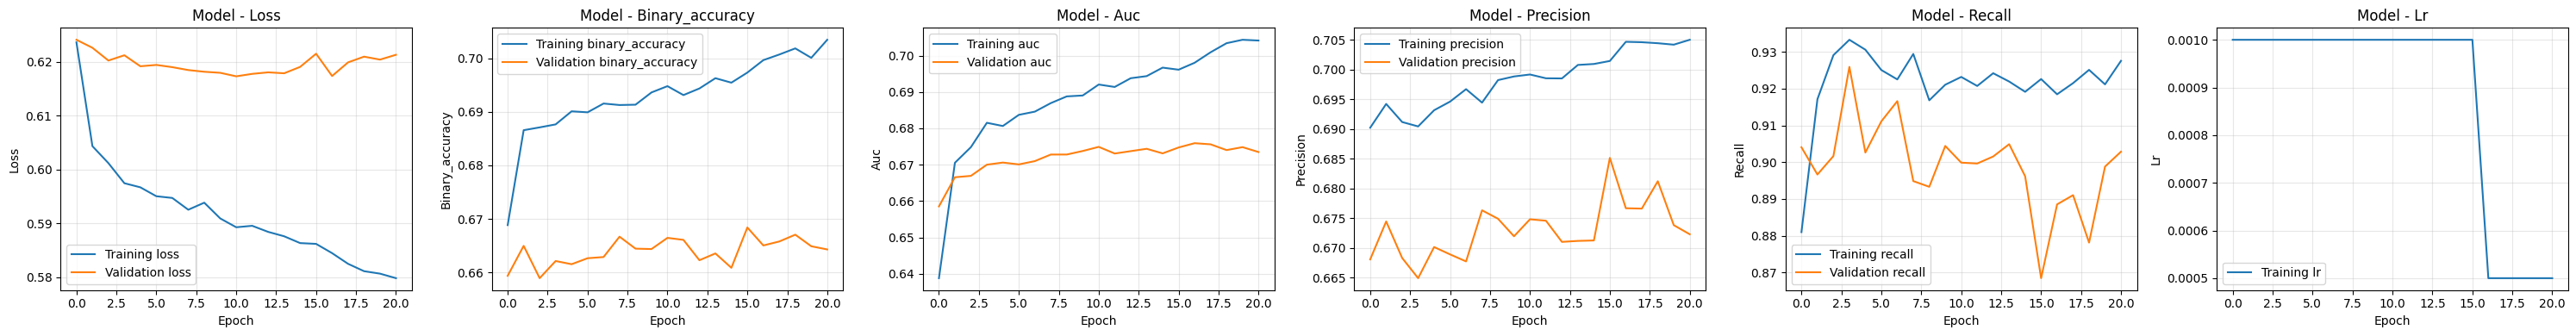

In [546]:
# 9.1 Visualization functions for training history

def plot_training_history(history, model_name="Model"):
    """
    Comprehensive visualization of training metrics.
    Shows loss, accuracy, and other metrics over epochs.
    """
    
    # Get available metrics from history
    metrics = [key for key in history.history.keys() if not key.startswith('val_')]
    n_metrics = len(metrics)
    
    # Create subplots
    fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4))
    if n_metrics == 1:
        axes = [axes]
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        
        # Plot training and validation curves
        ax.plot(history.history[metric], label=f'Training {metric}')
        if f'val_{metric}' in history.history:
            ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        
        ax.set_title(f'{model_name} - {metric.capitalize()}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history_lstm, "Model")


Analyzing prediction for test sample #1278
Label Strategy: INDEPENDENT

INDEPENDENT THRESHOLD PREDICTIONS:
----------------------------------------------------------------------
Threshold       | Predicted Prob |     Actual |     Status
----------------------------------------------------------------------
down 0.3%       |          0.641 |       ✗ No |    ✗ Wrong
up 0.3%         |          0.660 |      ✓ Yes |  ✓ Correct
GENERATING ADAPTIVE CALIBRATION PLOTS


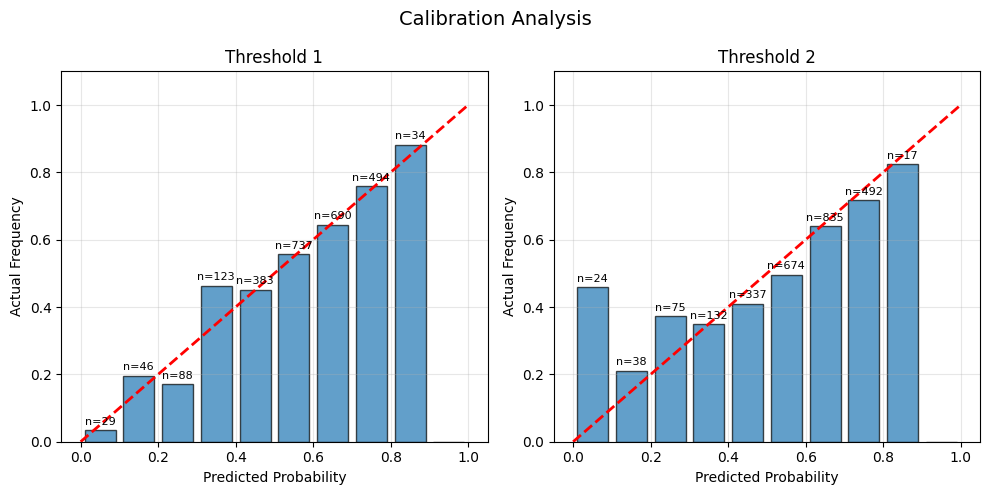

In [ ]:
# 9.2 Adapted evaluation functions for oscillation-based predictions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


def detect_label_strategy(label_columns):
    
    # Check for oscillation-specific patterns in column names
    has_oscillation = any('oscillation' in col for col in label_columns)
    has_only = any('_only_' in col for col in label_columns)
    
    if has_oscillation and has_only:
        strategy = 'oscillation'
        
        # Parse the threshold groups
        threshold_info = []
        oscillation_cols = [col for col in label_columns if 'oscillation' in col]
        print(oscillation_cols)
        for osc_col in oscillation_cols:
            # Extract threshold value from column name

            
            parts = osc_col.split('_')
            threshold_idx = parts.index('oscillation') + 1
            threshold2 = parts[threshold_idx].replace('pct', '')
            

            print(oscillation_cols)
            parts = osc_col.split('oscillation_')
            threshold = parts[1].replace('_', '.').replace('pct', '')
            print(oscillation_cols)
            
            # Find the corresponding up_only and down_only columns
            base_pattern = osc_col.replace('oscillation', '')
            up_col = [col for col in label_columns if 'up_only' in col and threshold2 in col]
            down_col = [col for col in label_columns if 'down_only' in col and threshold2 in col]
            print(up_col)
            threshold_info.append({
                'threshold': threshold,
                'oscillation_idx': label_columns.index(osc_col),
                'up_only_idx': label_columns.index(up_col[0]) if up_col else None,
                'down_only_idx': label_columns.index(down_col[0]) if down_col else None
            })
    else:
        strategy = 'independent'
        
        # Parse independent thresholds
        threshold_info = []
        for i, col in enumerate(label_columns):
            parts = col.split('_')
            direction = 'up' if 'up' in parts else 'down'
            
            # Extract threshold value
            if direction == 'up':
                threshold_start = parts.index('up') + 1
            else:
                threshold_start = parts.index('down') + 1
            
            threshold_parts = []
            for part in parts[threshold_start:]:
                if 'pct' in part:
                    threshold_parts.append(part.replace('pct', ''))
                    break
                else:
                    threshold_parts.append(part)
            
            threshold = '.'.join(threshold_parts) if len(threshold_parts) > 1 else threshold_parts[0]
            
            threshold_info.append({
                'direction': direction,
                'threshold': threshold,
                'index': i
            })
    
    return strategy, threshold_info

# %%
# Adapted visualization for single predictions

def visualize_single_prediction_adaptive(model, X_test_3d, y_test, labels_df, 
                                        sample_idx=None, window_size=48):
    
    # Detect the label strategy
    label_columns = [col for col in labels_df.columns if col.startswith('label_')]
    strategy, threshold_info = detect_label_strategy(label_columns)
    
    # Select a sample
    if sample_idx is None:
        sample_idx = np.random.randint(0, len(X_test_3d))
    
    print(f"\n{'='*70}")
    print(f"Analyzing prediction for test sample #{sample_idx}")
    print(f"Label Strategy: {strategy.upper()}")
    print('='*70)
    
    # Get the input window and predictions
    input_window = X_test_3d[sample_idx:sample_idx+1]
    actual_labels = y_test[sample_idx]
    predictions = model.predict(input_window, verbose=0)[0]
    
    if strategy == 'oscillation':
        print("\nMARKET BEHAVIOR PREDICTIONS:")
        print("-"*70)
        print(f"{'Threshold':<12} | {'Oscillation':>12} | {'Up Only':>12} | {'Down Only':>12} | {'Actual':<15}")
        print("-"*70)
        
        for info in threshold_info:
            threshold = info['threshold']
            osc_pred = predictions[info['oscillation_idx']]
            up_pred = predictions[info['up_only_idx']] if info['up_only_idx'] is not None else 0
            down_pred = predictions[info['down_only_idx']] if info['down_only_idx'] is not None else 0
            
            # Determine what actually happened
            osc_actual = actual_labels[info['oscillation_idx']]
            up_actual = actual_labels[info['up_only_idx']] if info['up_only_idx'] is not None else 0
            down_actual = actual_labels[info['down_only_idx']] if info['down_only_idx'] is not None else 0
            
            if osc_actual == 1:
                actual_str = "✓ Oscillation"
            elif up_actual == 1:
                actual_str = "↑ Up only"
            elif down_actual == 1:
                actual_str = "↓ Down only"
            else:
                actual_str = "− Neither"
            
            # Determine predicted behavior (highest probability)
            max_pred = max(osc_pred, up_pred, down_pred)
            if max_pred < 0.3:  # Low confidence in all
                predicted_behavior = "Uncertain"
            elif osc_pred == max_pred:
                predicted_behavior = "Oscillation"
            elif up_pred == max_pred:
                predicted_behavior = "Up trend"
            else:
                predicted_behavior = "Down trend"
            
            print(f"±{threshold}%      | {osc_pred:>11.1%} | {up_pred:>11.1%} | {down_pred:>11.1%} | {actual_str:<15}")
    
    else:  # independent strategy
        print("\nINDEPENDENT THRESHOLD PREDICTIONS:")
        print("-"*70)
        print(f"{'Threshold':<15} | {'Predicted Prob':>14} | {'Actual':>10} | {'Status':>10}")
        print("-"*70)
        
        for info in threshold_info:
            direction = info['direction']
            threshold = info['threshold']
            idx = info['index']
            
            pred_prob = predictions[idx]
            actual = "✓ Yes" if actual_labels[idx] == 1 else "✗ No"
            
            # Check if prediction was correct
            if (pred_prob > 0.5 and actual_labels[idx] == 1) or \
               (pred_prob <= 0.5 and actual_labels[idx] == 0):
                status = "✓ Correct"
            else:
                status = "✗ Wrong"
            
            threshold_str = f"{direction} {threshold}%"
            print(f"{threshold_str:<15} | {pred_prob:>14.3f} | {actual:>10} | {status:>10}")
    

# Adapted calibration plots for oscillation labels

def create_calibration_plots_adaptive(model, X_test_3d, y_test, labels_df, n_bins=10):
    
    print("GENERATING ADAPTIVE CALIBRATION PLOTS")
    print("="*70)
    
    # Detect strategy
    label_columns = [col for col in labels_df.columns if col.startswith('label_')]
    strategy, threshold_info = detect_label_strategy(label_columns)
    
    # Get predictions
    y_pred_proba = model.predict(X_test_3d, verbose=0)
    
    if strategy == 'oscillation':
        # For oscillation labels, create one plot per outcome type per threshold
        n_thresholds = len(threshold_info)
        fig, axes = plt.subplots(n_thresholds, 3, figsize=(15, 5*n_thresholds))
        
        if n_thresholds == 1:
            axes = axes.reshape(1, -1)
        
        for t_idx, t_info in enumerate(threshold_info):
            threshold = t_info['threshold']
            
            # Three subplots: oscillation, up_only, down_only
            outcome_types = [
                ('oscillation', t_info['oscillation_idx'], 'Oscillation'),
                ('up_only', t_info['up_only_idx'], 'Up Only'),
                ('down_only', t_info['down_only_idx'], 'Down Only')
            ]
            
            for o_idx, (outcome_name, label_idx, title) in enumerate(outcome_types):
                if label_idx is None:
                    axes[t_idx, o_idx].set_visible(False)
                    continue
                
                ax = axes[t_idx, o_idx]
                
                # Get predictions and actuals for this outcome
                y_pred_i = y_pred_proba[:, label_idx]
                y_true_i = y_test[:, label_idx]
                
                # Create calibration bins
                bin_edges = np.linspace(0, 1, n_bins + 1)
                bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
                
                actual_freq = []
                bin_counts = []
                
                for i in range(n_bins):
                    bin_mask = (y_pred_i >= bin_edges[i]) & (y_pred_i < bin_edges[i+1])
                    if i == n_bins - 1:
                        bin_mask = (y_pred_i >= bin_edges[i]) & (y_pred_i <= bin_edges[i+1])
                    
                    n_in_bin = np.sum(bin_mask)
                    bin_counts.append(n_in_bin)
                    
                    if n_in_bin > 0:
                        actual_freq.append(np.mean(y_true_i[bin_mask]))
                    else:
                        actual_freq.append(0)
                
                # Create bar plot
                bars = ax.bar(bin_centers, actual_freq, width=0.08, alpha=0.7,
                             edgecolor='black')
                
                # Add diagonal line
                ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect calibration')
                
                # Add sample counts
                for bar, count in zip(bars, bin_counts):
                    if count > 0:
                        height = bar.get_height()
                        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                               f'n={count}', ha='center', va='bottom', fontsize=8)
                
                ax.set_xlabel('Predicted Probability')
                ax.set_ylabel('Actual Frequency')
                ax.set_title(f'±{threshold}% - {title}')
                ax.set_xlim([-0.05, 1.05])
                ax.set_ylim([0, 1.1])
                ax.grid(True, alpha=0.3)
                ax.legend(fontsize=8)
        
        plt.suptitle('Calibration Analysis for Oscillation Strategy', fontsize=14)
        
    else:  # Independent labels - use original approach
        # Original calibration plot code here
        n_thresholds = y_test.shape[1]
        n_cols = min(4, n_thresholds)
        n_rows = (n_thresholds + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
        
        if n_thresholds == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes
        else:
            axes = axes.flatten()
        
        for idx in range(n_thresholds):
            ax = axes[idx] if n_thresholds > 1 else axes
            
            y_pred_i = y_pred_proba[:, idx]
            y_true_i = y_test[:, idx]
            
            # Create bins and calculate frequencies
            bin_edges = np.linspace(0, 1, n_bins + 1)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            actual_freq = []
            bin_counts = []
            
            for i in range(n_bins):
                bin_mask = (y_pred_i >= bin_edges[i]) & (y_pred_i < bin_edges[i+1])
                if i == n_bins - 1:
                    bin_mask = (y_pred_i >= bin_edges[i]) & (y_pred_i <= bin_edges[i+1])
                
                n_in_bin = np.sum(bin_mask)
                bin_counts.append(n_in_bin)
                
                if n_in_bin > 0:
                    actual_freq.append(np.mean(y_true_i[bin_mask]))
                else:
                    actual_freq.append(0)
            
            bars = ax.bar(bin_centers, actual_freq, width=0.08, alpha=0.7,
                         edgecolor='black')
            ax.plot([0, 1], [0, 1], 'r--', linewidth=2)
            
            for bar, count in zip(bars, bin_counts):
                if count > 0:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'n={count}', ha='center', va='bottom', fontsize=8)
            
            ax.set_xlabel('Predicted Probability')
            ax.set_ylabel('Actual Frequency')
            ax.set_title(f'Threshold {idx+1}')
            ax.set_xlim([-0.05, 1.05])
            ax.set_ylim([0, 1.1])
            ax.grid(True, alpha=0.3)
        
        plt.suptitle('Calibration Analysis', fontsize=14)
    
    plt.tight_layout()
    plt.show()

# 1. Visualize single predictions:
visualize_single_prediction_adaptive(model_lstm, X_test_3d, y_test, labels_df)

# 2. Create calibration plots:
create_calibration_plots_adaptive(model_lstm, X_test_3d, y_test, labels_df)